In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
from glob import glob
from pprint import pprint

In [56]:
region_frequency_paths = glob('../../data/frequencies/*.csv')
region_dfs = {}
for path in region_frequency_paths:
    region = path.split('/')[-1].split('_frequencies.csv')[0]
    region_dfs[region] = pd.read_csv(path, index_col=0)

In [57]:
def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = np.linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = np.linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

colors = assign_genotype_colors(region_dfs['southeast_asia'].columns.values)

In [83]:
def parse_seasons(df):
    ''' Adds 'season' column to df; drop inter-season rows '''
    
    def bin_seasons(numdate):
        seasons = [(year + 5./12., year + 364./365.) 
                    for year in range(1970, 2017)]
        season = np.nan
        for start, end in seasons:
            if numdate >= start and numdate<= end:
                season = (start, end)
                break
        return season

    pivots = df.index
    df['season'] = pivots.map(bin_seasons)
    df.dropna(subset=['season'], inplace=True)
    return df

def find_replicates(g1, g2, df):
    ''' Find all seasons that g1 and g2 both circulated at >= 5% frequency '''
    try:
        g1_seasons = df[df[g1] >= 0.05]['season'].tolist()
        g2_seasons = df[df[g2] >= 0.05]['season'].tolist()
        cocirculating_seasons = set(g1_seasons).intersection(set(g2_seasons))
        return sorted(list(cocirculating_seasons))
    except KeyError:
        print 'Oops, one or both of these genotypes was not in the dataframe.'
        print g1, g2
        print df.columns.values
        return []
    
    
def find_start_end_frequencies(g1, g2, season, df):
    ''' For a given season, returns the genotype frequencies of g1 and g2 
    at the first and last timepoints in that season'''
    season_frequencies = df[df['season'] == season]

    g1_start, g2_start = season_frequencies.iloc[0][g1], season_frequencies.iloc[0][g2]
    g1_end, g2_end = season_frequencies.iloc[-1][g1], season_frequencies.iloc[-1][g2]

    return {g1: (g1_start, g1_end), g2: (g2_start, g2_end)}
    
def collect_outcomes(g1, g2, df):
    cocirculating_seasons = find_replicates(g1, g2, df)
    outcomes = {int(season[0]) : find_start_end_frequencies(g1,g2,season, df) for season in cocirculating_seasons}
    return outcomes
    

In [60]:
region_dfs['southeast_asia'] = parse_seasons(region_dfs['southeast_asia'])
region_dfs['south_america'] = parse_seasons(region_dfs['south_america'])

In [84]:
genotype_antigenic_distance = pd.read_csv('../../data/katzelnick2015/processed/genotypes_normalized.csv')
genotype_antigenic_distance = genotype_antigenic_distance.groupby(['serum_genotype', 'virus_genotype'])['autologous_norm'].agg('mean')
genotype_antigenic_distance.sort_values(inplace=True, ascending=False)
genotype_antigenic_distance.dropna(inplace=True)

def fix_genotype_names((g1,g2)):
    g1 = g1.replace('/', '').replace(' ', '').upper()
    g1 = g1[:5]+'_'+g1[5:]
    g2 = g2.replace('/', '').replace(' ', '').upper()
    g2 = g2[:5]+'_'+g2[5:]    
    return (g1, g2)

ranked_genotype_pairs = [fix_genotype_names((g1,g2)) for (g1,g2) in genotype_antigenic_distance.index.values]
ranked_genotype_pairs = [(g1,g2) for (g1,g2) in ranked_genotype_pairs if 
                        len(find_replicates(g1,g2,region_dfs['southeast_asia'])) > 2]
most_distinct = ranked_genotype_pairs[:10]
most_similar = ranked_genotype_pairs[-10:]

Oops, one or both of these genotypes was not in the dataframe.
DENV1_I DENV2_AMERICAN
['DENV1_I' 'DENV1_II' 'DENV1_IV' 'DENV1_V' 'DENV2_ASIANAMERICAN'
 'DENV2_ASIANI' 'DENV2_COSMOPOLITAN' 'DENV2_SYLVATIC' 'DENV3_I' 'DENV3_II'
 'DENV3_III' 'DENV3_IV' 'DENV4_I' 'DENV4_II' 'DENV4_SYLVATIC' 'season']
Oops, one or both of these genotypes was not in the dataframe.
DENV2_AMERICAN DENV1_IV
['DENV1_I' 'DENV1_II' 'DENV1_IV' 'DENV1_V' 'DENV2_ASIANAMERICAN'
 'DENV2_ASIANI' 'DENV2_COSMOPOLITAN' 'DENV2_SYLVATIC' 'DENV3_I' 'DENV3_II'
 'DENV3_III' 'DENV3_IV' 'DENV4_I' 'DENV4_II' 'DENV4_SYLVATIC' 'season']
Oops, one or both of these genotypes was not in the dataframe.
DENV2_COSMOPOLITAN DENV2_AMERICAN
['DENV1_I' 'DENV1_II' 'DENV1_IV' 'DENV1_V' 'DENV2_ASIANAMERICAN'
 'DENV2_ASIANI' 'DENV2_COSMOPOLITAN' 'DENV2_SYLVATIC' 'DENV3_I' 'DENV3_II'
 'DENV3_III' 'DENV3_IV' 'DENV4_I' 'DENV4_II' 'DENV4_SYLVATIC' 'season']
Oops, one or both of these genotypes was not in the dataframe.
DENV3_II DENV2_AMERICAN
['DENV1

In [90]:
def plot_outcomes(outcomes, ax, g1, g2):
    ''' Draws "slope plot" for outcomes of each season where g1 and g2 have cocirculated '''
    sns.set_style('whitegrid')
    ax.set_title('%s\n%s'%(g1, g2))
    ax.set_ylim(0,.5)
    ax.set_xlim(0,1)
    ax.set_xticks([])

    start_x = 0.25
    end_x = 0.75
    
    for season in sorted(outcomes.keys()):
        frequencies = outcomes[season]
        ax.scatter(start_x, frequencies[g1][0], c=colors[g1])
        ax.scatter(end_x, frequencies[g1][1], c=colors[g1])
        ax.plot((start_x, end_x), (frequencies[g1][0], frequencies[g1][1]), c=colors[g1])

        ax.scatter(start_x, frequencies[g2][0], c=colors[g2])
        ax.scatter(end_x, frequencies[g2][1], c=colors[g2])
        ax.plot((start_x, end_x), (frequencies[g2][0], frequencies[g2][1]), c=colors[g2])

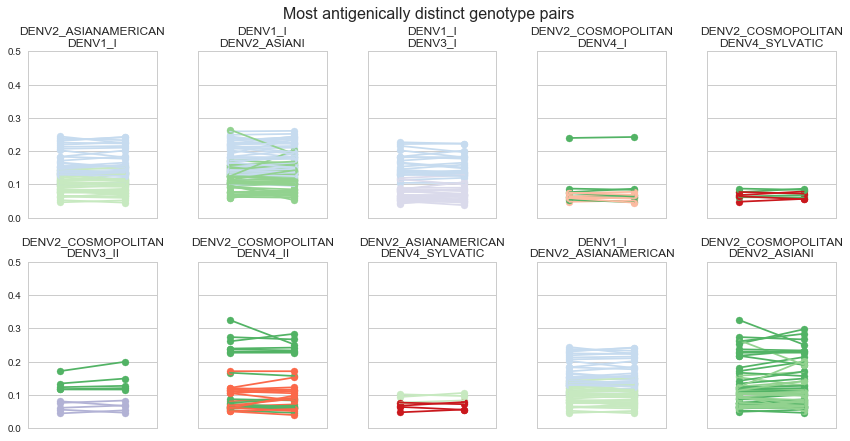

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=len(most_distinct)/2, sharey=True, figsize=(12,6))
axes = axes.flatten()
plt.suptitle('Most antigenically distinct genotype pairs', va='bottom', size=16)

for ax, (g1, g2) in zip(axes, most_distinct):
    outcomes = collect_outcomes(g1, g2, region_dfs['southeast_asia'])
    plot_outcomes(outcomes, ax, g1, g2)
    
plt.tight_layout()
plt.show()

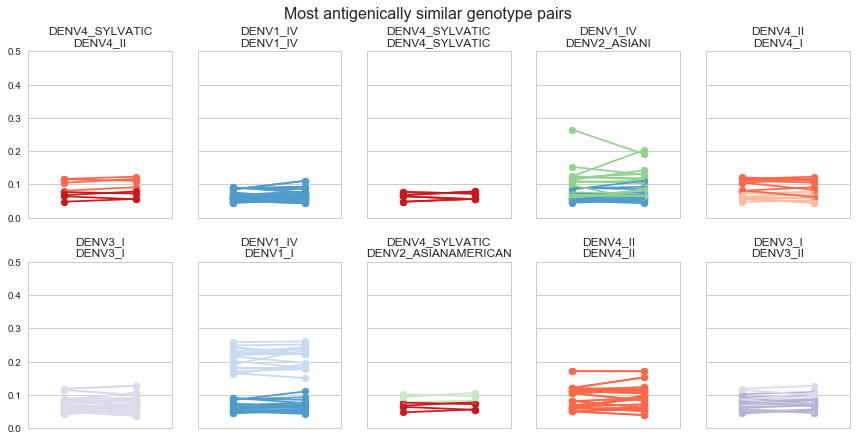

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=len(most_distinct)/2, sharey=True, figsize=(12,6))
axes = axes.flatten()
plt.suptitle('Most antigenically similar genotype pairs', va='bottom', size=16)

for ax, (g1, g2) in zip(axes, most_similar):
    outcomes = collect_outcomes(g1, g2, region_dfs['southeast_asia'])
    plot_outcomes(outcomes, ax, g1, g2)
    
plt.tight_layout()
plt.show()